In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
from os.path import join, exists
import os
import requests
import time
from pytube import YouTube
import numpy as np
import torch
import torchvision
import whisper
from IPython.display import Video
import pandas as pd
# from decord import VideoReader

from utils.io import load_json
from utils.visualize import show_grid_of_images

In [3]:
# Set the API key
curr_filepath = os.path.dirname(os.path.abspath('__file__'))
curr_dirname = os.path.dirname(curr_filepath)
filename=os.path.join(curr_dirname, "secrets/youtube_api.json")
print(filename)
assert os.path.exists(filename), "Please create a file with your youtube api key"

/Users/piyush/projects/YouTube-scrapper-tutorial/secrets/youtube_api.json


In [4]:
API_KEY = load_json(filename)["api_key"]

In [63]:
base_url = "https://www.googleapis.com/youtube/v3/search"

# Set the parameters for the API request
params = {
    "part": "snippet",  # Return snippet metadata for each video
    "q": "origami",    # Search for videos that contain the word "origami"
    "key": API_KEY,    # Your API key
    "maxResults": 50,  # Return up to 100 results per request
    # Include the full description in the response
    # "fields": "items(id,snippet(channelId,channelTitle,title,description(full)))",
}

# Make the API request
response = requests.get(base_url, params=params)

# Print the metadata for each video
print("Number of responsed:", len(response.json()["items"]))
for video in response.json()["items"]:
    print(video["snippet"])
    break

Number of responsed: 50
{'publishedAt': '2022-04-23T12:45:02Z', 'channelId': 'UC8lnmTA5u9sfqbHtDeNClAQ', 'title': 'Оригами Прыгающий Осьминог из бумаги | Игрушка Антистресс | Origami Paper Jumping Octopus', 'description': 'В этом видео покажу, как сделать оригами антистресс - прыгающего осьминога из бумаги! А если нажимать на осьминожку ...', 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/vef3JKIsDgI/default.jpg', 'width': 120, 'height': 90}, 'medium': {'url': 'https://i.ytimg.com/vi/vef3JKIsDgI/mqdefault.jpg', 'width': 320, 'height': 180}, 'high': {'url': 'https://i.ytimg.com/vi/vef3JKIsDgI/hqdefault.jpg', 'width': 480, 'height': 360}}, 'channelTitle': 'Hello Origami', 'liveBroadcastContent': 'none', 'publishTime': '2022-04-23T12:45:02Z'}


In [47]:
len(response.json()["items"])

50

In [65]:
info = video["snippet"]
video_id = video["id"]["videoId"]
video_url = f"https://www.youtube.com/watch?v={video_id}"

In [67]:
info.update(video["id"])

In [68]:
info

{'publishedAt': '2022-04-23T12:45:02Z',
 'channelId': 'UC8lnmTA5u9sfqbHtDeNClAQ',
 'title': 'Оригами Прыгающий Осьминог из бумаги | Игрушка Антистресс | Origami Paper Jumping Octopus',
 'description': 'В этом видео покажу, как сделать оригами антистресс - прыгающего осьминога из бумаги! А если нажимать на осьминожку ...',
 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/vef3JKIsDgI/default.jpg',
   'width': 120,
   'height': 90},
  'medium': {'url': 'https://i.ytimg.com/vi/vef3JKIsDgI/mqdefault.jpg',
   'width': 320,
   'height': 180},
  'high': {'url': 'https://i.ytimg.com/vi/vef3JKIsDgI/hqdefault.jpg',
   'width': 480,
   'height': 360}},
 'channelTitle': 'Hello Origami',
 'liveBroadcastContent': 'none',
 'publishTime': '2022-04-23T12:45:02Z',
 'kind': 'youtube#video',
 'videoId': 'vef3JKIsDgI'}

In [57]:
len(video["snippet"]["description"])

127

In [8]:
def download_video(video_id, save_dir, ext='mp4', resolution="360p", **kwargs):
    video_url = f"https://www.youtube.com/watch?v={video_id}"

    start = time.time()
    try:
        yt = YouTube(video_url)
        streams = yt.streams.filter(
            file_extension=ext, res=resolution, **kwargs,
        )
    except:
        status = "UNAVAILABLE"
        return {"video_id": video_id, "status": status, "download_time": 0}

    try:
        streams[0].download(output_path=save_dir, filename=f"{video_id}.{ext}")
        status = "SUCCESS"
    except:
        status = "FAIL"

    end = time.time()
    download_time = end - start
    
    return {"video_id": video_id, "status": status, "download_time": download_time}

In [9]:
data_root = "/Users/piyush/datasets/"
save_dir = join(data_root, "Origami/videos")

In [10]:
download_video(video_id, save_dir)

{'video_id': 'vef3JKIsDgI',
 'status': 'SUCCESS',
 'download_time': 1.3412489891052246}

In [11]:
video_path = join(save_dir, f"{video_id}.mp4")
assert exists(video_path)

In [43]:
video, audio, meta = torchvision.io.read_video(video_path, pts_unit="sec", start_pts=100., end_pts=120.0)

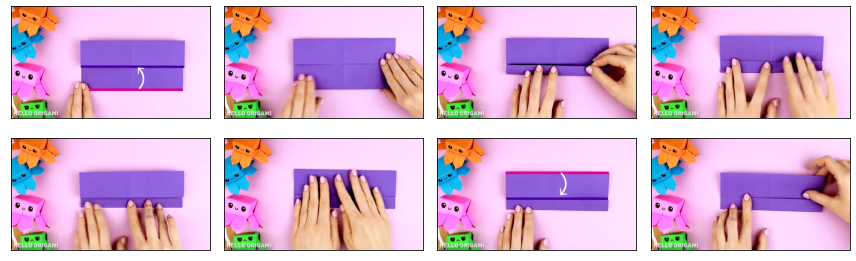

In [44]:
indices = np.linspace(0, len(video) - 1, 8, dtype=int)
frames = video[indices]
show_grid_of_images(frames.numpy(), n_cols=4, figsize=(12, 4))

### Get metadata of as many videos as possible

In [78]:
def search_based_on_query(query="origami", prev_response=None):
    base_url = "https://www.googleapis.com/youtube/v3/search"

    # Set the parameters for the API request
    params = {
        "part": "snippet",  # Return snippet metadata for each video
        "q": "origami",    # Search for videos that contain the word "origami"
        "key": API_KEY,    # Your API key
        "maxResults": 50,  # Return up to 100 results per request
    }
    if prev_response is not None:
        params.update({"pageToken": prev_response.json().get("nextPageToken", None)})

    # Make the API request
    response = requests.get(base_url, params=params)

    # Print the metadata for each video
    try:
        print("Number of responses:", len(response.json()["items"]))
        video_info = []
        for video in response.json()["items"]:
            info = video["snippet"]
            info.update(video["id"])
            video_info.append(info)
        return video_info, response
    except:
        return [], response
    
    # return video_info, response

In [79]:
metadata = []

video_info, response = search_based_on_query(query="origami")
metadata.extend(video_info)
while len(video_info) > 0:
    video_info, response = search_based_on_query(query="origami", prev_response=response)
    metadata.extend(video_info)

Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 1
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 50
Number of responses: 0


In [80]:
len(metadata)

1001

In [85]:
metadata[700]

{'publishedAt': '2022-11-08T13:00:28Z',
 'channelId': 'UCYVKzEFIO9JfsbhsriTttrg',
 'title': 'How to make EASY paper POPPER [origami banger, loud paper banger]',
 'description': "Slow video: https://youtu.be/FJAyfi6xuLs Hey Crafties! It's time for fun crafts at school to surprise your friends! Let's learn how to ...",
 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/vpINloTOhFQ/default.jpg',
   'width': 120,
   'height': 90},
  'medium': {'url': 'https://i.ytimg.com/vi/vpINloTOhFQ/mqdefault.jpg',
   'width': 320,
   'height': 180},
  'high': {'url': 'https://i.ytimg.com/vi/vpINloTOhFQ/hqdefault.jpg',
   'width': 480,
   'height': 360}},
 'channelTitle': "Polly's origami",
 'liveBroadcastContent': 'none',
 'publishTime': '2022-11-08T13:00:28Z',
 'kind': 'youtube#video',
 'videoId': 'vpINloTOhFQ'}

In [92]:
titles = []
for m in metadata:
    titles.append(m["title"])
titles_cut = [t[:70] for t in titles]

In [93]:
len(titles)

1001

In [94]:
from IPython.display import display, Markdown
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import clip
from PIL import Image
from sklearn.cluster import KMeans

from utils.visualize import bokeh_2d_scatter_new, get_text_features, reduce_dim


In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [96]:
X = get_text_features(titles_cut, model, device, batch_size=16)

Getting text features: 100%|████████████████████| 63/63 [00:14<00:00,  4.31it/s]


In [97]:
# apply clustering on X
km = KMeans(n_clusters=10)
km.fit(X)
labels = km.labels_

/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [98]:
Z = reduce_dim(X)

In [99]:
X.shape, X.shape


((1001, 512), (1001, 512))

In [103]:
df = pd.DataFrame(Z)
df["label"] = titles
df["dataset"] = "Origami"
df["cluster"] = labels

In [106]:
bokeh_2d_scatter_new(
    df=df,
    x=0,
    y=1,
    hue="cluster",
    label="label",
    use_nb=True,
    title="Clustering CLIP embeddings of video task descriptions in collected 1001 Origami videos",
)

[autoreload of bokeh.core.property.bases failed: Traceback (most recent call last):
  File "/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/piyush/miniforge3/envs/yt/lib/python3.9/site-packages/IPython/extensions/autoreload.py", 

AttributeError: type object 'Model' has no attribute 'model_class_reverse_map'

In [105]:
!pip install --upgrade bokeh==2.4.3

     |████████████████████████████████| 18.5 MB 887 kB/s            
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.0.3
    Uninstalling bokeh-3.0.3:
      Successfully uninstalled bokeh-3.0.3
